We've previously found that modeling set outcomes tends to perform better than modeling match outcomes, when evaluated on predicting match outcomes.  This is true on both an AUC and an Accuracy basis.  However, the AUC improvement occurs despite not taking into account, at prediction time, whether we are predicting the outcome of a best-of-3 or best-of-5 match.  Upsets occur much more easily in best-of-three than best-of-five matches.  Here, we attempt to improve model performance by transforming set predictions into the appropriate match predictions.  To do so, we use the formulae below, where $\hat{p}$ is our predicted set probability:

$\begin{align}
    \mathbb{P}_2 &= \hat{p}^2(1 + 2(1 - \hat{p})) \\
    \mathbb{P}_3 &= \hat{p}^3(1 + 3(1 - \hat{p}) + {4 \choose 2}(1 - \hat{p})^2)
\end{align} \\
\text{where } \hat{p} \text{ is the set prediction}
$


In [1]:
from tennis_new.fetch.tennis_explorer.combiner import read_joined

jd = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv_377/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [2]:
jd['p1_sets_won'].value_counts(dropna=False)

2.0    913434
1.0     36528
3.0     15579
4.0        12
NaN         7
Name: p1_sets_won, dtype: int64

In [3]:
import numpy as np

jd['best_of'] = jd['p1_sets_won'].map({
    1.: 3,
    2.: 3,
    3.: 5,
    4.: 3,
    np.nan: 3
})

In [4]:
from tennis_new.model.config.elo.global_set_elo import SetELO

set_elo = SetELO()
set_elo.run(jd)
set_elo.validation_evaluation

{'DummyFilter_prediction_AUCMetric': 0.8187031847302881,
 'DummyFilter_prediction_AccuracyMetric': 0.7358520800135314,
 'DummyFilter_prediction_LogLikelihoodMetric': -0.5226366377611569,
 'HasOddsFilter_prediction_AUCMetric': 0.786068092124641,
 'HasOddsFilter_prediction_AccuracyMetric': 0.7080332235338619,
 'HasOddsFilter_prediction_LogLikelihoodMetric': -0.5576990341361893,
 'DummyFilter_odds_implied_probability_AUCMetric': None,
 'DummyFilter_odds_implied_probability_AccuracyMetric': None,
 'DummyFilter_odds_implied_probability_LogLikelihoodMetric': None,
 'HasOddsFilter_odds_implied_probability_AUCMetric': 0.7955634245248138,
 'HasOddsFilter_odds_implied_probability_AccuracyMetric': 0.7200428690759507,
 'HasOddsFilter_odds_implied_probability_LogLikelihoodMetric': -0.5484675296646053}

Now that we have our original SetELO model, let's see what our calculation adjustment gets us! 

In [5]:
def adjust_for_match_length(p, best_of):
    if best_of == 3:
        return (p ** 2) * (1. + 2. * (1 - p))
    elif best_of == 5:
        out = 0
        out += p ** 3  # Straight Sets
        out += 3 * (p ** 3) * (1 - p)  # 4 sets
        out += 6 * (p ** 3) * ((1 - p) ** 2) # 5 sets
        return out
    else:
        raise ValueError("Unexpected Match Length")

class SetELOWithCalculations(SetELO):

    def post_process(self):
        new_preds = self.all_jd[['best_of', 'prediction']].apply(
            lambda x: adjust_for_match_length(x['prediction'], x['best_of']),
            axis=1
        )
        self.all_jd['unadjusted_pred'] = self.all_jd['prediction']
        self.all_jd['prediction'] = new_preds.values
        
adjusted_set_elo = SetELOWithCalculations()
adjusted_set_elo.run(jd)

In [6]:
adjusted_set_elo.validation_evaluation

{'DummyFilter_prediction_AUCMetric': 0.8187661398370436,
 'DummyFilter_prediction_AccuracyMetric': 0.7358520800135314,
 'DummyFilter_prediction_LogLikelihoodMetric': -0.5263718356952306,
 'HasOddsFilter_prediction_AUCMetric': 0.7862599786271594,
 'HasOddsFilter_prediction_AccuracyMetric': 0.7080332235338619,
 'HasOddsFilter_prediction_LogLikelihoodMetric': -0.5581285702662083,
 'DummyFilter_odds_implied_probability_AUCMetric': None,
 'DummyFilter_odds_implied_probability_AccuracyMetric': None,
 'DummyFilter_odds_implied_probability_LogLikelihoodMetric': None,
 'HasOddsFilter_odds_implied_probability_AUCMetric': 0.7955634245248138,
 'HasOddsFilter_odds_implied_probability_AccuracyMetric': 0.7200428690759507,
 'HasOddsFilter_odds_implied_probability_LogLikelihoodMetric': -0.5484675296646053}

Above, we see that we get a slight boost to the AUC, but surprisingly enough, the log likelihood worsens!  Overall, this seems worth doing, but not tremendously important.  There aren't very many five set matches, which might explain the overall lack of importance here.  To investigate the decrease in log likelihood, let's look at calibration plots.

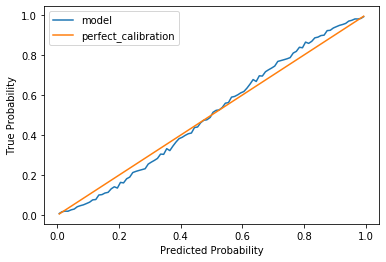

In [7]:
%matplotlib inline
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt

def calibration_plot(df):
    preds = np.concatenate([
        df['prediction'].values,
        1. - df['prediction'].values
    ])
    ys = np.concatenate([
        np.ones(len(df)),
        np.zeros(len(df))
    ])
    _y, _x = calibration_curve(ys, preds, n_bins=100)
    plt.plot(_x, _y, label='model')
    plt.plot(_x, _x, label='perfect_calibration')
    plt.legend()
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    
validation_set = set_elo.validation_filter.filter_data(set_elo.all_jd)
calibration_plot(validation_set)

Above, we see that without the adjustment, our predictions are not extreme enough.  Let's see how the adjustment changes this...

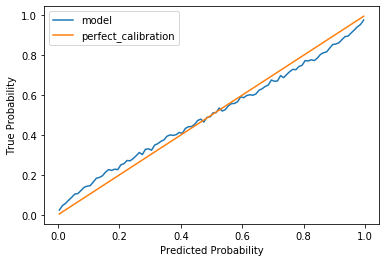

In [8]:
validation_set = adjusted_set_elo.validation_filter.filter_data(adjusted_set_elo.all_jd)
calibration_plot(validation_set)

It's now the opposite!  Here are a couple theories as to what's going on:

1) The underlying set probabilities are too extreme
2) Perhaps the i.i.d. assumption is a bit much!

It seems like perhaps a best-of specific calibration function would address either issue, but as a first step, we can investigate the first theory (TODO in the future: Look into whether set probabilities are properly calibrated).